In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
from tqdm import tqdm
from functions import (
    get_var_hist,
    get_p_x4_short_time,
)
from setup import setup_matplotlib, one_col, std_height, two_col
from functions import SimulationManager, SolverManager, EigenvectorManager, forces_dict
from timeit import default_timer as timer

setup_matplotlib()

np.random.seed(42)

In [16]:
version = 2

s = 1
D = s**2 / 2
max_t = 6  # 2
ntau = 2  # 3
N_x = 61  # 25
hist_sigma = 4
force = "cubic"
avg_part = 4
measure = 'var'

f = 15
N_p = 2_000
N_loop = 20
ntau_sim = f * ntau

ltaus = np.concatenate(([0, 0.01,0.02,0.03,0.04 ,0.05], np.arange(0.1, 1.01, 0.1)))
# ltaus = np.array([0, 0.003,0.004, 0.005, 0.006,0.0075, 0.01, 0.0125, 0.015,0.0175, 0.02, 0.025,0.03, 0.05])

sim_vars = np.empty((len(ltaus), 4))
num_vars = np.empty((len(ltaus), 4))
sim_hist_vars = np.empty((len(ltaus), 4))
eig_vars = np.empty((len(ltaus), 2))
short_time_approx_var = np.empty(len(ltaus))
escaped_traj = np.empty(len(ltaus))
sbs = np.empty(len(ltaus))

In [17]:
my_sim_manager = SimulationManager()

for i, ltau in enumerate(tqdm(ltaus)):
    ldt = ltau / ntau_sim if ltau > 0 else ltaus[1] / ntau_sim
    N_t = int(max_t / ldt) + 1
    # filter = [-np.sqrt(7/4/ltau), np.sqrt(7/4/ltau)] if ltau > 0 else None
    filter = [-hist_sigma, hist_sigma]

    res = my_sim_manager.run(
        N_p=N_p,
        N_loop=N_loop,
        N_t=N_t,
        N_x=N_x,
        ntau=ntau_sim if ltau > 0 else 0,
        s=s,
        dt=ldt,
        x_0=0,
        force=force,
        hist_sigma=hist_sigma,
        norm_sigma=True,
        measure=measure,
        filter = filter,
    )

    sim_ts = np.arange(0, (N_t + ntau_sim)) * ldt - ltau
    sim_var = res["sim_var"]
    sim_hist_var = res["sim_hist_var"]
    hist_sum = res["hist_sum"]
    x_s = res["x_s"]
    sbs[i] = -x_s[0]

    high_res_x_s = np.linspace(x_s[0], x_s[-1], 1000)
    short_time_p = get_p_x4_short_time(high_res_x_s, ltau)
    short_time_approx_var[i] = get_var_hist(short_time_p, high_res_x_s)

    escaped_traj[i] = 1 - np.sum(hist_sum[:, -1]) / (N_p * N_loop)

    mean_sim_vars = np.mean(sim_var[:, -N_t // avg_part :], axis=1)
    sim_vars[i] = (
        np.mean(mean_sim_vars),
        np.std(mean_sim_vars) / np.sqrt(N_loop),
        np.min(np.mean(sim_var[:, -N_t // avg_part :], axis=0)),
        np.max(np.mean(sim_var[:, -N_t // avg_part :], axis=0)),
    )

    mean_sim_hist_var = np.mean(sim_hist_var[:, -N_t // avg_part :], axis=1)
    sim_hist_vars[i] = (
        np.mean(mean_sim_hist_var),
        np.std(mean_sim_hist_var) / np.sqrt(N_loop),
        np.min(np.mean(sim_hist_var[:, -N_t // avg_part :], axis=0)),
        np.max(np.mean(sim_hist_var[:, -N_t // avg_part :], axis=0)),
    )

100%|██████████| 16/16 [00:00<00:00, 292.92it/s]


In [18]:
my_num_manager = SolverManager()

for i, ltau in enumerate(tqdm(ltaus)):
    ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
    N_t = int(max_t / ldt) + 1
    ts = np.arange(0, N_t) * ldt
    sb = sbs[i]

    res = my_num_manager.run(
        N_t=N_t,
        N_x=N_x,
        sb=sb,
        ntau=ntau if ltau > 0 else 0,
        s=s,
        dt=ldt,
        x_0=0,
        force=force,
        version=version,
        measure=measure,
    )

    num_var = res["num_var"]
    mean_num_var = np.mean(num_var[-N_t // avg_part :])
    num_vars[i] = (
        mean_num_var,
        0,
        np.min(num_var[-N_t // avg_part :]),
        np.max(num_var[-N_t // avg_part :]),
    )

100%|██████████| 16/16 [00:00<00:00, 895.57it/s]


In [19]:
eigen_manager = EigenvectorManager()

for i, ltau in enumerate(tqdm(ltaus[ltaus < np.pi / 2])):
    ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
    sb = sbs[i]

    res = eigen_manager.run(
        N_x=N_x,
        sb=sb,
        ntau=ntau if ltau > 0 else 0,
        s=s,
        dt=ldt,
        force=force,
        version=version,
        measure=measure,
    )
    eig_vars[i] = (res["eig_var"], 0)

100%|██████████| 16/16 [00:00<00:00, 683.19it/s]


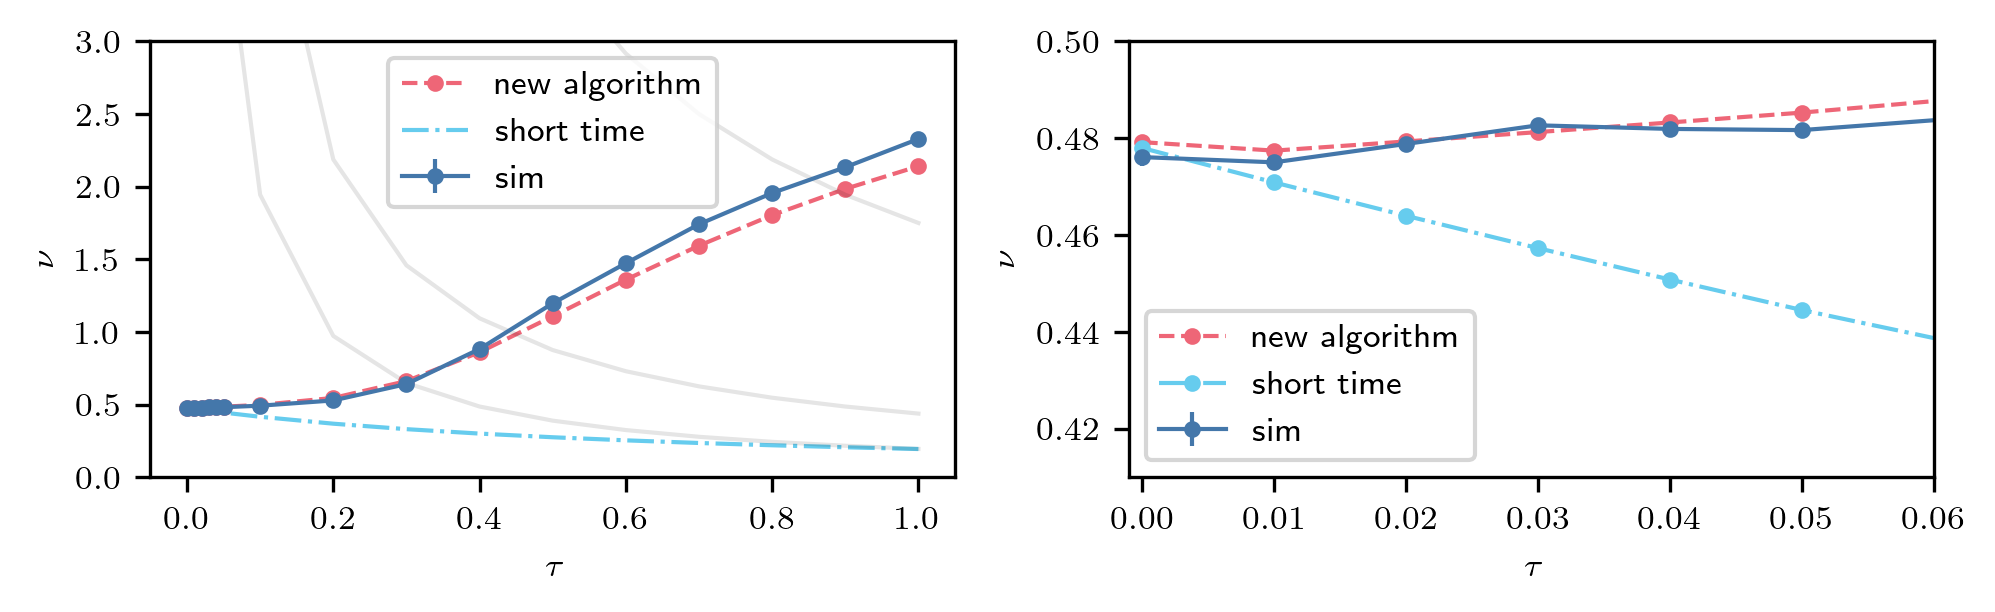

In [20]:
plt.figure(figsize=(two_col, std_height))
ax = plt.subplot(121)
plt.errorbar(ltaus, *sim_vars.T[:2], marker=".", color = 'C0', label="sim")
# plt.errorbar(ltaus, *sim_hist_vars.T[:2], marker=".", ls="-", label="hist-sim")
plt.plot(ltaus, num_vars[:, 0], marker=".", ls="--", color = 'C1',label="new algorithm")
# plt.plot(ltaus, eig_vars[:,0], marker=".", ls="--", color = 'C2', label="eigenvector")

plt.plot(ltaus, short_time_approx_var, marker=None, ls="-.", color = "C4", label="short time")


# plt.yscale('log')
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\nu$")
plt.ylim(*plt.ylim())
# auflösungslimit std same as div x0

# plt.plot(ltaus, (2/3)**2*ltaus**(-1), color = 'black')
plt.plot(ltaus[1:],         (np.sqrt(7) / 2) ** 2 * ltaus[1:] ** (-1), alpha = 0.1, color="black")
plt.plot(ltaus[1:], 1 / 4 * (np.sqrt(7) / 2) ** 2 * ltaus[1:] ** (-1), alpha = 0.1, color="black")
plt.plot(ltaus[1:], 1 / 9 * (np.sqrt(7) / 2) ** 2 * ltaus[1:] ** (-1), alpha = 0.1 ,color="black")

# plt.xlim(0,0.2)
plt.ylim(0,3)

# ax = plt.subplot(122)
# plt.errorbar(
#     ltaus,
#     num_vars[:, 0] / sim_vars[:, 0],
#     yerr=np.sqrt(
#         (num_vars[:, 1] / sim_vars[:, 0]) ** 2
#         + (num_vars[:, 0] / sim_vars[:, 0] ** 2 * sim_vars[:, 1]) ** 2
#     ),
#     marker=".",
#     color = 'C1'
# )
# plt.xlabel(r"$\tau$")
# plt.ylabel(r"deviation")
plt.subplot(122)
plt.errorbar(ltaus, *sim_vars.T[:2], marker=".", color = 'C0', label="sim")
# plt.errorbar(ltaus,*sim_hist_vars.T[:2],marker='.', ls = '-', label='hist-sim')
plt.plot(ltaus, num_vars[:, 0], marker=".", ls="--", color = 'C1', label="new algorithm")
# plt.plot(ltaus, eig_vars[:,0], marker=".", ls="--", color = 'C2', label="eigenvector")

plt.plot(ltaus, short_time_approx_var, ".-.", color = 'C4', label="short time")

plt.xlim(-0.001, 0.06)
plt.ylim(0.41, 0.5)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\nu$")

plt.tight_layout()
plt.savefig(f'graphics/x4variance_v{version}_{force}.pdf')

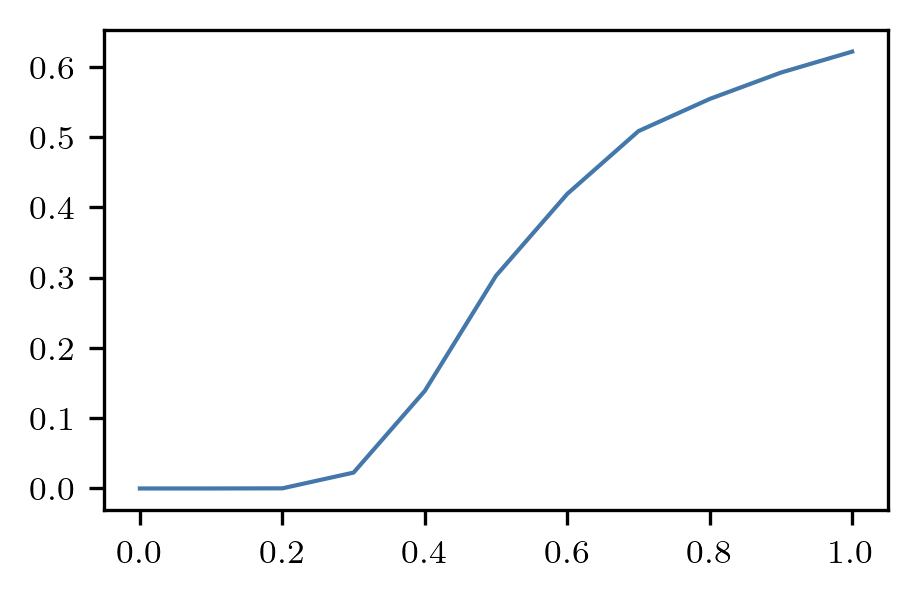

In [21]:
plt.plot(ltaus, escaped_traj)

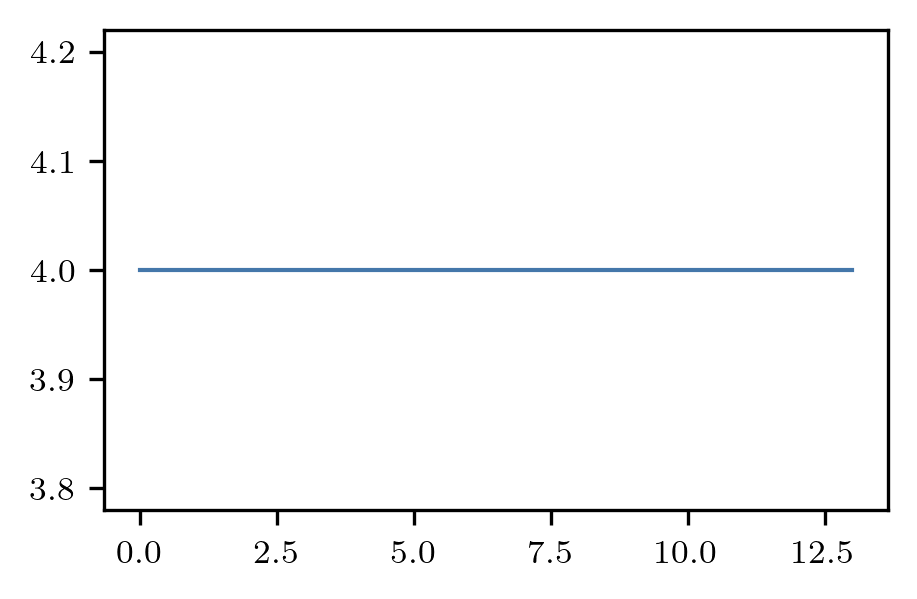

In [22]:
plt.plot(sbs[:-2])

# Test short time approx -- approved

In [23]:
# dt = 0.01
# N_loop = 10
# N_p = 2_000
# N_t = 5_000
# N_x = 50

# ltaus = np.concatenate(([0.05], np.arange(0.1,1.1,0.1) ))
# #ltaus = [0.05]
# sim_vars = np.empty((len(ltaus),2))
# sim_hist_vars = np.empty((len(ltaus),2))
# short_time_approx_var = np.empty(len(ltaus))

# for i, tau in enumerate(tqdm(ltaus)):
#     def f_a(x):
#         return -x**3*(1 + 3*tau*x**2)
#     def g_a(x):
#         return (1 + 3*tau*x**2)

#     pos = np.empty((N_loop,N_p,N_t))
#     vel = np.empty((N_loop,N_p,N_t))

#     pos[:,:,0] = 0
#     vel[:,:,0] = 0

#     for j in tqdm(range(1,N_t), leave=False):
#         pos[:,:,j] = pos[:,:,j-1] + vel[:,:,j-1]*dt
#         vel[:,:,j] = f_a(pos[:,:,j]) + g_a(pos[:,:,j])*1/np.sqrt(dt)*np.random.randn(N_loop,N_p)

#     pos_filter = pos.copy()
#     if tau > 0:
#         pos_filter[pos_filter**2 > 7/4/tau] = np.nan
#     sim_var = np.nanvar(pos_filter, axis = 1)

#     sb = 3*np.sqrt(np.max(sim_var))
#     dx = 2*sb/(N_x-1)
#     x_s = np.arange(-sb,sb+1e-6,dx)
#     bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)


#     sim_hists = np.swapaxes(np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1,2)
#     sim_hist_var =  np.apply_along_axis(get_var_hist,-1, sim_hists, x_s=x_s)

#     short_time_p = get_p_x4_short_time(x_s, tau)
#     short_time_approx_var[i] = get_var_hist(short_time_p,x_s)

#     mean_sim_vars = np.mean(sim_var[:,-500:], axis = 1)
#     sim_vars[i] = (np.mean(mean_sim_vars), np.std(mean_sim_vars)/np.sqrt(N_loop))

#     mean_sim_hist_var = np.mean(sim_hist_var[:,-500:], axis = 1)
#     sim_hist_vars[i] = (np.mean(mean_sim_hist_var), np.std(mean_sim_hist_var)/np.sqrt(N_loop))

In [24]:
# plt.plot(sim_var[0])
# plt.plot(sim_hist_var[0])
# plt.hlines(short_time_approx_var[-1], *plt.xlim())
# plt.xlim(0,100)

In [25]:
# plt.plot(ltaus, short_time_approx_var, label = 'short time')
# plt.plot(ltaus, sim_hist_vars[:,0], label = 'sim hists')
# plt.plot(ltaus, sim_vars[:,0], label = 'sim')
# plt.legend()